In [57]:
import psycopg2
import pandas as pd

import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler

from functools import reduce

hostname = 'lebanon'
dbname = 'cs_mdfps'
username = 'cschiebroek' 
import json
from rdkit import Chem


In [8]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

In [9]:


# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
        public.conformers.molregno,
        cs_mdfps_schema.mdfp_experiment_data.mdfp,
        cs_mdfps_schema.experimental_data.vp_log10Pa,
        public.conformers.molblock
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''

# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]
molblocks = [r[4] for r in results]
df_mdfps = pd.DataFrame({'confid': confids, 'molregno': molregnos, 'mdfp': mdfps, 'vp': vps, 'molblock': molblocks})
cur.close()
cn.close()

16977 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa', 'molblock']


In [61]:
df_mdfps2 = df_mdfps.drop_duplicates(subset=['molregno'])
mols_registered = [Chem.MolFromMolBlock(mb) for mb in df_mdfps2['molblock']]
print(len(df_mdfps2))
#canonical_mols
canonical_mols_with_mdfp = [Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols_registered]

[13:19:42] Warning: molecule is tagged as 3D, but all Z coords are zero


2981


In [62]:
df_original_298_dup_dropped = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/VP_data_no_duplicates.tsv', sep='\t')
mols = [Chem.MolFromSmiles(mb) for mb in df_original_298_dup_dropped['SMILES']]
canonical_mols_registered = [Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols]


In [69]:
#check if all mols are in the canonical_mols_registered. loop over both, if they have substruc match to eachother then they are the same, otherways append to list of missing mols
from tqdm import tqdm
missing_mols = []
for mol in tqdm(canonical_mols_registered):
    found_match = False
    for mol2 in canonical_mols_with_mdfp:
        if mol.HasSubstructMatch(mol2) and mol2.HasSubstructMatch(mol):
            found_match = True
            break
    if not found_match:
        missing_mols.append(mol)
print(len(missing_mols))

100%|██████████| 3042/3042 [00:08<00:00, 365.75it/s]

61


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


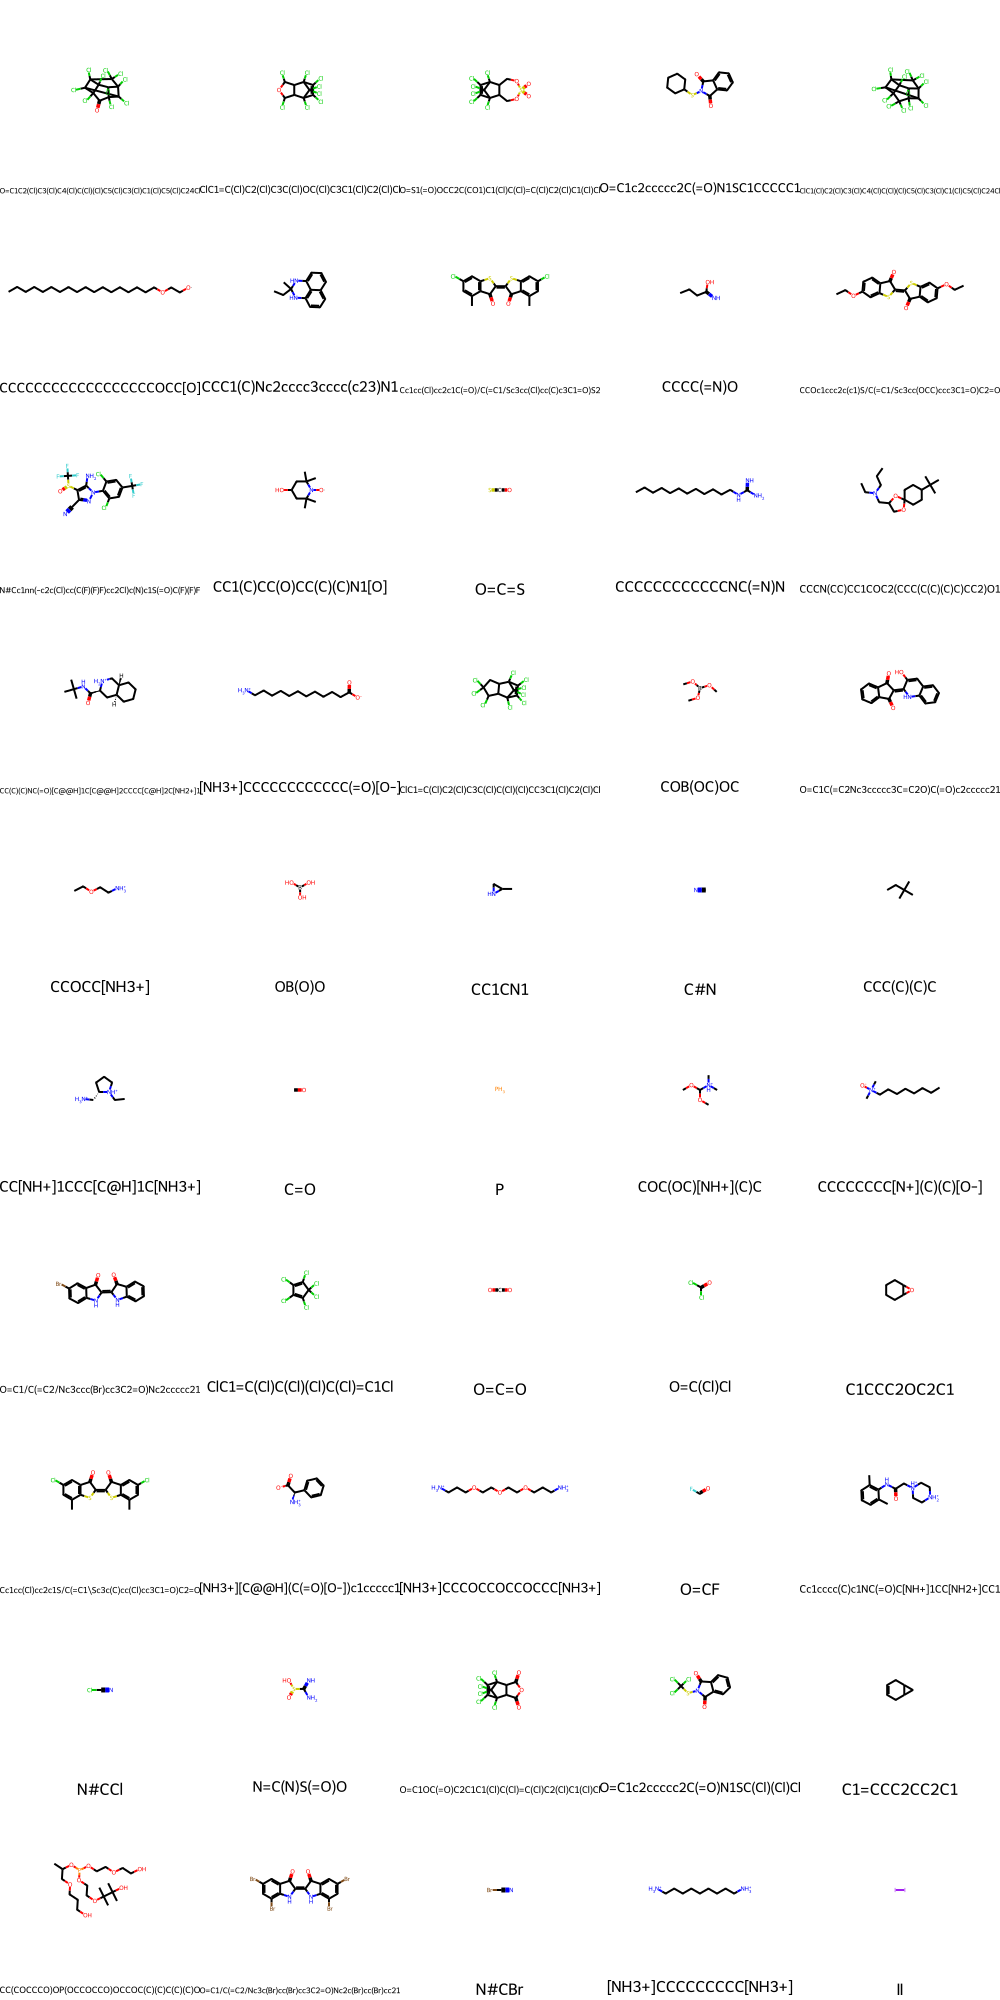

In [70]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(missing_mols, molsPerRow=5, subImgSize=(200,200), legends=[Chem.MolToSmiles(mol) for mol in missing_mols])

In [71]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass

In [76]:
molregnos_missing_registered = []
mols_not_registered = []
for mol in missing_mols:
    query = lwreg.query(config=config, mol=mol)
    print(query)
    if query:
        molregno = query[0]
        molregnos_missing_registered.append(molregno)
    else:
        mols_not_registered.append(mol)

[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(Cl)C5(Cl)C24Cl
[13:31:19] New largest fragment: O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(Cl)C5(Cl)C24Cl (21)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: ClC1=C(Cl)C2(Cl)C3C(Cl)OC(Cl)C3C1(Cl)C2(Cl)Cl
[13:31:19] New largest fragment: ClC1=C(Cl)C2(Cl)C3C(Cl)OC(Cl)C3C1(Cl)C2(Cl)Cl (22)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: O=S1(=O)OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl
[13:31:19] New largest fragment: O=S1(=

[]
[]
[]
[181]
[]
[271]
[294]
[345]
[]
[374]
[]


[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: CC1(C)CC(O)CC(C)(C)N1[O]
[13:31:19] New largest fragment: CC1(C)CC(O)CC(C)(C)N1[O] (30)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: O=C=S
[13:31:19] New largest fragment: O=C=S (3)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: CCCCCCCCCCCCNC(=N)N
[13:31:19] New largest fragment: CCCCCCCCCCCCNC(=N)N (45)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running L

[671]
[715]
[]
[]
[899]
[900]
[]
[913]
[1003]
[1024]


[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: OB(O)O
[13:31:19] New largest fragment: OB(O)O (7)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: CC1CN1
[13:31:19] New largest fragment: CC1CN1 (11)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: C#N
[13:31:19] New largest fragment: C#N (3)
[13:31:19] Initializing MetalDisconnector
[13:31:19] Running MetalDisconnector
[13:31:19] Initializing Normalizer
[13:31:19] Running Normalizer
[13:31:19] Running LargestFragmentChooser
[13:31:19] Fragment: CCC(C)(C)C
[13:31:19] Ne

[2344]
[]
[2407]
[2455]
[]
[2529]
[2799]
[2822]
[2825]


[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: O=C1/C(=C2/Nc3ccc(Br)cc3C2=O)Nc2ccccc21
[13:31:20] New largest fragment: O=C1/C(=C2/Nc3ccc(Br)cc3C2=O)Nc2ccccc21 (30)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: ClC1=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl
[13:31:20] New largest fragment: ClC1=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl (11)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: O=C=O
[13:31:20] New largest fragment: O=C=O (3)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer


[2853]
[2879]
[2881]
[2926]
[]
[3087]
[3096]
[3140]
[3157]


[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: Cc1cccc(C)c1NC(=O)C[NH+]1CC[NH2+]CC1
[13:31:20] New largest fragment: Cc1cccc(C)c1NC(=O)C[NH+]1CC[NH2+]CC1 (41)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: N#CCl
[13:31:20] New largest fragment: N#CCl (3)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: N=C(N)S(=O)O
[13:31:20] New largest fragment: N=C(N)S(=O)O (10)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20]

[3161]
[3301]
[]
[]
[3532]
[]
[]
[3669]
[3711]


[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: [NH3+]CCCCCCCCC[NH3+]
[13:31:20] New largest fragment: [NH3+]CCCCCCCCC[NH3+] (35)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: II
[13:31:20] New largest fragment: II (2)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: ClC1=C(Cl)C2(Cl)C3C4OC4C(Cl)C3C1(Cl)C2(Cl)Cl
[13:31:20] New largest fragment: ClC1=C(Cl)C2(Cl)C3C4OC4C(Cl)C3C1(Cl)C2(Cl)Cl (23)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] R

[3728]
[3738]
[]
[]
[15649]
[4065]
[4080]
[4109]
[]
[4172]
[4188]
[4204]
[4207]


[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: NC(=O)CC[C@H](NC(=O)C[NH3+])C(=O)[O-]
[13:31:20] New largest fragment: NC(=O)CC[C@H](NC(=O)C[NH3+])C(=O)[O-] (27)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: [NH3+]C[C@@H]1CCC[C@H](C[NH3+])C1
[13:31:20] New largest fragment: [NH3+]C[C@@H]1CCC[C@H](C[NH3+])C1 (30)
[13:31:20] Initializing MetalDisconnector
[13:31:20] Running MetalDisconnector
[13:31:20] Initializing Normalizer
[13:31:20] Running Normalizer
[13:31:20] Running LargestFragmentChooser
[13:31:20] Fragment: [O-][n+]1nc(-n2ccnc2)nc2ccc(Cl)cc21
[13:31:20] New largest fragment: [O-][n+]1nc(-n2ccnc2)nc2ccc(Cl)cc21 (23)


In [77]:
len(molregnos_missing_registered)

42

In [78]:
len(mols_not_registered)

19

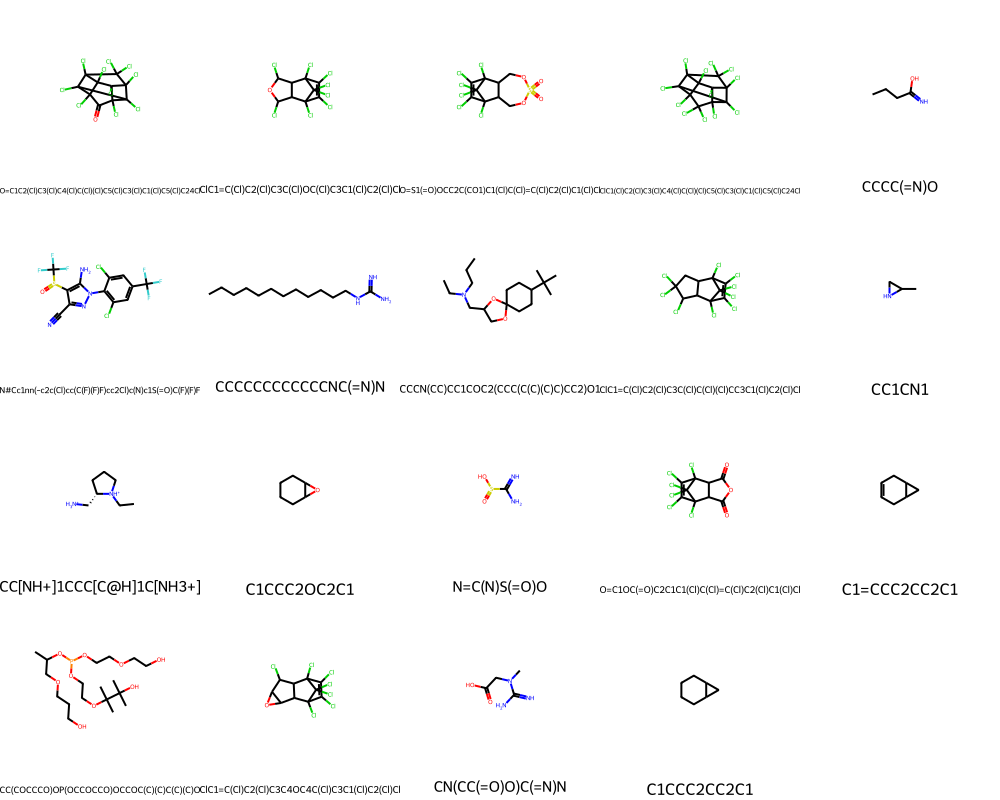

In [79]:
Draw.MolsToGridImage(mols_not_registered, molsPerRow=5, subImgSize=(200,200), legends=[Chem.MolToSmiles(mol) for mol in mols_not_registered])

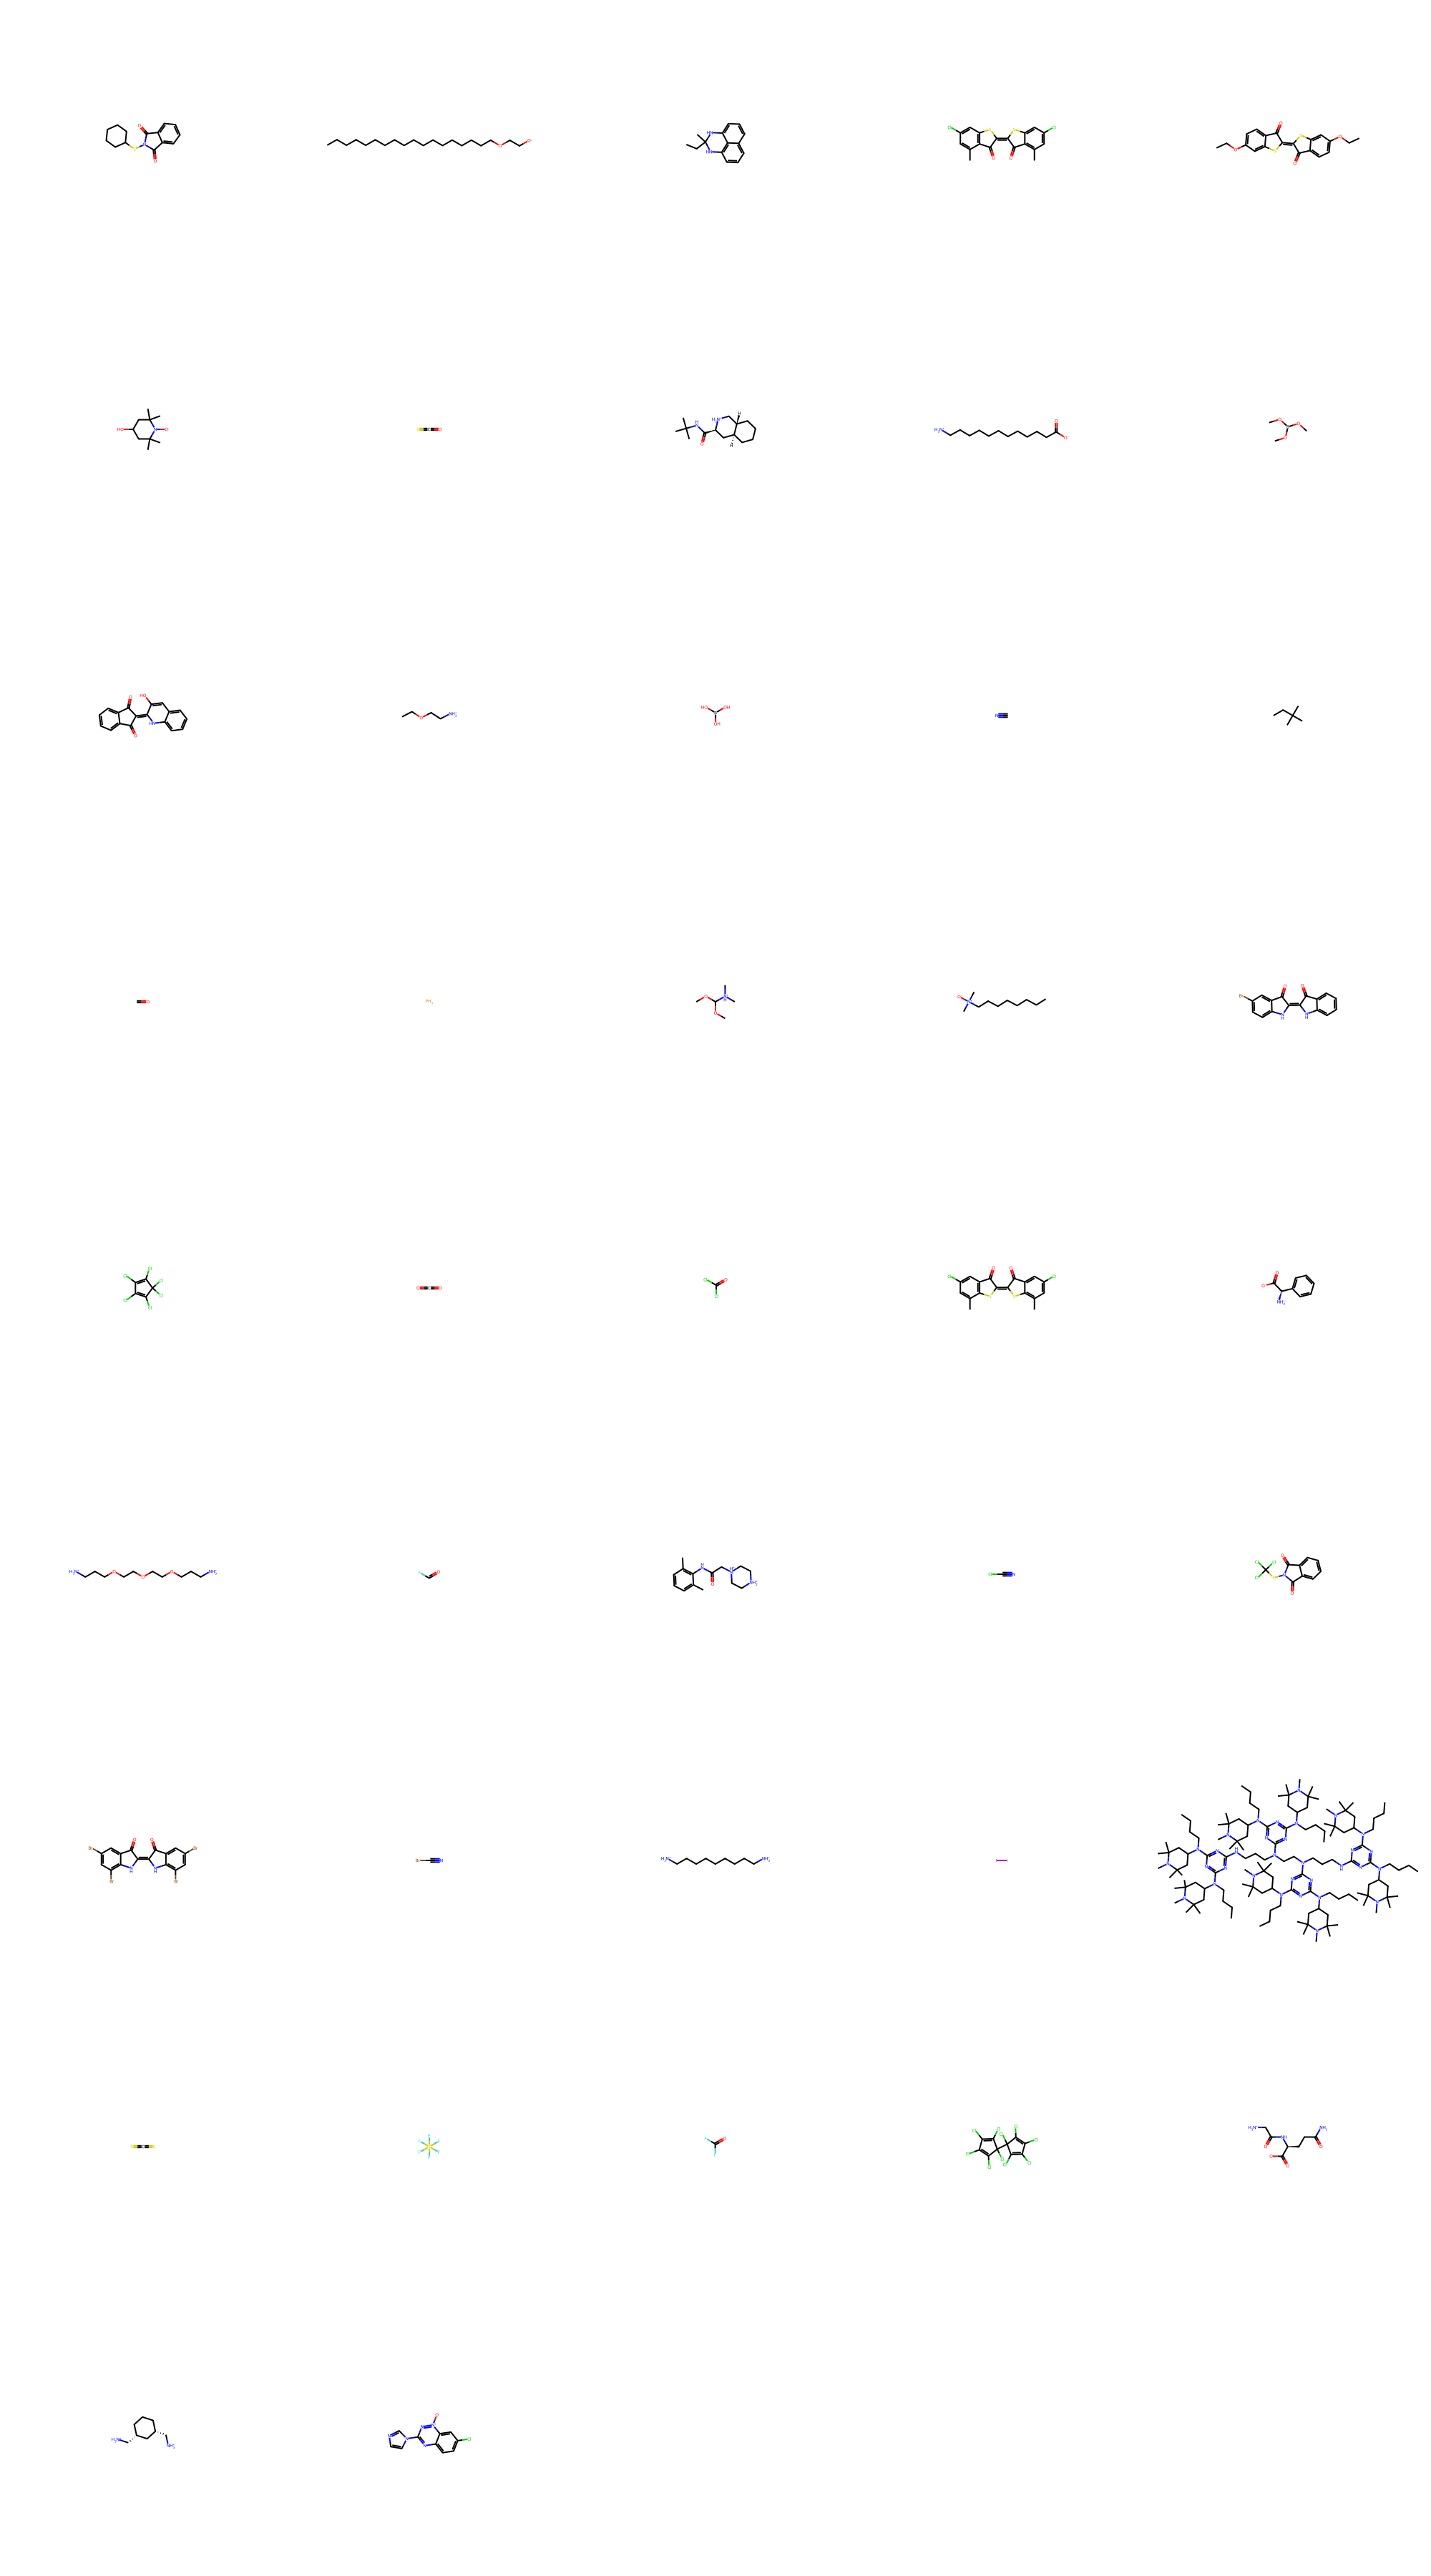

In [83]:
missing_mols_registerd = [m for m in missing_mols if m not in mols_not_registered]
Draw.MolsToGridImage(missing_mols_registerd, molsPerRow=5, subImgSize=(400,400))

In [48]:
df = pd.read_csv('../Experiments_result_analysis/mdfp_and_rdkit_features_2993_DASHprops.csv')
print(len(df))

2993


In [52]:
df
#drop duplicate molregnos
df = df.drop_duplicates(subset=['molregno'])
len(df)

2993